In [1]:
#!pip install bayesian-optimization
#!pip install shap

In [1]:
import pandas as pd
import numpy as np
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold #StratifiedFOld es util para clases desbalanceadas
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, make_scorer, recall_score, accuracy_score, precision_score

In [2]:
from pylab import rcParams
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedBaggingClassifier
 
from collections import Counter

### Lectura de datos y mini EDA

In [3]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [4]:
#df = pd.read_csv('dataset_final.csv', low_memory=False)
df = pd.read_csv('/home/mmontero/Escritorio/Proyectos/greenpeace/Modelo_fuga/modelo_VERSION_SERVER-sin_var_cate/validation.csv')

In [5]:
df.head()

constituent_id rg_status  target  cnu_count_last_year  \
0         276474    Active       0                    0   
1         276498    Active       0                    0   
2         276498    Active       1                    0   
3         276505    Active       0                    0   
4         276628    Active       0                    0   

   do_not_want_last_year  upgrades_last_year  downgrades_all_history  \
0                      0                   0                       1   
1                      0                   0                       0   
2                      0                   0                       0   
3                      0                   0                       0   
4                      0                   0                       0   

   upgrades_all_history  first_payment_amount        amount  \
0                     3                  3999   2031.428571   
1                     1                  4000   2000.000000   
2                     1                  4000   2000.000000   
3                     3                  4999  12532.857143   
4                     1                  4000   5237.000000   

   days_since_last_regular_gift  received_installments  \
0                           178                     29   
1                           716                      9   
2                           696                      9   
3                            26                     57   
4                           341                     37   

   failed_installment_count  total_received  age  unified_lifetime  \
0                        14   132500.952381   44                58   
1                         6    36000.000000   60                65   
2                         6    36000.000000   60                64   
3                         0   533586.666667   54                58   
4                         2   179548.352941   22                56   

   days_since_activation_to_first_payment     avg_gift  effectiveness_debit  \
0                                      33  4480.645518             0.511771   
1                                      34  4000.000000             0.138483   
2                                      34  4000.000000             0.140625   
3                                      33  9309.624862             0.980954   
4                                      64  4806.601104             0.662478   

   cod_last_upg_response  
0                      5  
1                      5  
2                      5  
3                      5  
4                      5

In [6]:
df.shape

(6164, 20)

In [7]:
df = df.drop_duplicates()

In [8]:
df.shape

(6164, 20)

In [10]:
# Transform categorical features into the appropriate type that is expected by LightGBM
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6164 entries, 0 to 6163
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   constituent_id                          6164 non-null   category
 1   rg_status                               6164 non-null   category
 2   target                                  6164 non-null   int64   
 3   cnu_count_last_year                     6164 non-null   int64   
 4   do_not_want_last_year                   6164 non-null   int64   
 5   upgrades_last_year                      6164 non-null   int64   
 6   downgrades_all_history                  6164 non-null   int64   
 7   upgrades_all_history                    6164 non-null   int64   
 8   first_payment_amount                    6164 non-null   int64   
 9   amount                                  6164 non-null   float64 
 10  days_since_last_regular_gift            6164 non

In [12]:
dummy_columns = [] #array for multiple value columns
binarie_var = []
for column in df.columns:
    if df[column].dtype.name == 'category':
        if df[column].nunique() == 2:
            binarie_var.append(column)
        else:
            dummy_columns.append(column)

In [13]:
dummy_columns

['constituent_id', 'rg_status']

In [14]:
df.head()

constituent_id rg_status  target  cnu_count_last_year  \
0         276474    Active       0                    0   
1         276498    Active       0                    0   
2         276498    Active       1                    0   
3         276505    Active       0                    0   
4         276628    Active       0                    0   

   do_not_want_last_year  upgrades_last_year  downgrades_all_history  \
0                      0                   0                       1   
1                      0                   0                       0   
2                      0                   0                       0   
3                      0                   0                       0   
4                      0                   0                       0   

   upgrades_all_history  first_payment_amount        amount  \
0                     3                  3999   2031.428571   
1                     1                  4000   2000.000000   
2                     1                  4000   2000.000000   
3                     3                  4999  12532.857143   
4                     1                  4000   5237.000000   

   days_since_last_regular_gift  received_installments  \
0                           178                     29   
1                           716                      9   
2                           696                      9   
3                            26                     57   
4                           341                     37   

   failed_installment_count  total_received  age  unified_lifetime  \
0                        14   132500.952381   44                58   
1                         6    36000.000000   60                65   
2                         6    36000.000000   60                64   
3                         0   533586.666667   54                58   
4                         2   179548.352941   22                56   

   days_since_activation_to_first_payment     avg_gift  effectiveness_debit  \
0                                      33  4480.645518             0.511771   
1                                      34  4000.000000             0.138483   
2                                      34  4000.000000             0.140625   
3                                      33  9309.624862             0.980954   
4                                      64  4806.601104             0.662478   

   cod_last_upg_response  
0                      5  
1                      5  
2                      5  
3                      5  
4                      5

### Validation

In [15]:
import pickle #to save and load model trained

In [16]:
#model = load('RF-cluster.joblib')
model = pickle.load( open( "LightGBM-smartTrain.pickle", "rb" ))

In [18]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [20]:
y_test = df[['target']]
X_test = df.drop(['target', 'constituent_id'], axis=1)

In [21]:
threshold = 0.5

#predicted_proba = model.predict_proba(X_train)
predicted_proba = model.predict_proba(X_test)
pred_y = (predicted_proba[:,1] >= threshold).astype('int')

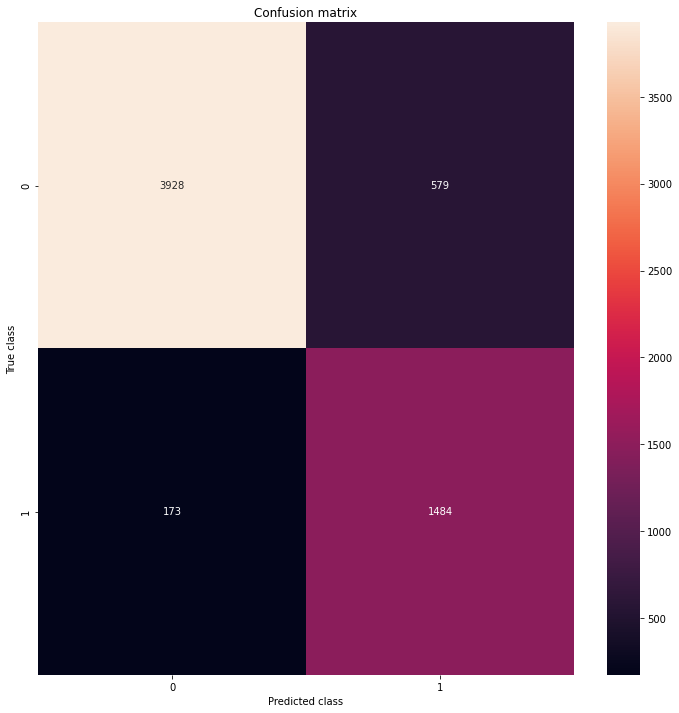

In [22]:
#pred_y = model.predict(X_test) #.predict() tira 0 o 1, predict_proba() tira la probabilidad
#mostrar_resultados(y_train, pred_y) # The default threshold for RandomForestClassifier is 0.5
mostrar_resultados(y_test, pred_y)

In [23]:
#print(classification_report(y_train, pred_y))
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      4507
           1       0.72      0.90      0.80      1657

    accuracy                           0.88      6164
   macro avg       0.84      0.88      0.86      6164
weighted avg       0.89      0.88      0.88      6164



In [24]:
from sklearn.metrics import fbeta_score
fbeta_score(y_test, pred_y, beta=.3)
#fbeta_score(y_train, pred_y, beta=.3)

0.7312228485667661

### Distribucion de probabilidades

In [25]:
lr_probs = model.predict_proba(X_test)
#lr_probs = model.predict_proba(X_train)

In [26]:
model.classes_

array([0, 1])

In [27]:
sort = sorted([c[1] for c in lr_probs], reverse = True)

In [28]:
sort

[0.9994230254413098,
 0.998973832233495,
 0.9987704915751459,
 0.998738985453734,
 0.9986308630558778,
 0.9986268752670181,
 0.9984810535978071,
 0.998473319336178,
 0.9984696833680471,
 0.9981140873928137,
 0.9981121168932193,
 0.9980706881229162,
 0.9979173809018271,
 0.9978488175438225,
 0.9976287661062866,
 0.9974091208765477,
 0.9973975888750888,
 0.9972710800457443,
 0.9971908043648331,
 0.9968046533133916,
 0.996746298230035,
 0.9966531693269421,
 0.9966350180181412,
 0.9964874500849625,
 0.9964792194505405,
 0.9963981374449357,
 0.996362350862844,
 0.99632230201726,
 0.9963127239715259,
 0.9962129325607664,
 0.9960764217040309,
 0.9959865659287784,
 0.9959113855501819,
 0.9959097070649567,
 0.9956728594091867,
 0.99564804874153,
 0.9955115403935717,
 0.995464462536716,
 0.9953988239223834,
 0.9952258195214129,
 0.9951617037116217,
 0.9951202885149235,
 0.9950647649061324,
 0.9949368659879309,
 0.9949122662108354,
 0.9948283731647667,
 0.9948149798281417,
 0.9948088562599621,
 0

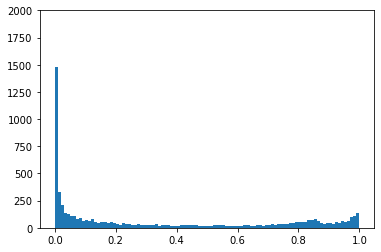

In [29]:
plt.hist(sort, bins = 100)
plt.ylim(0, 2000)
plt.show()

### Armamamos dataframe con probabilidades

In [30]:
probabilidades = pd.DataFrame(lr_probs)

In [31]:
probabilidades.rename(columns={0: "target.0", 1: "target.1"}, inplace = True)

In [32]:
probabilidades.head()

target.0  target.1
0  0.999059  0.000941
1  0.895624  0.104376
2  0.036486  0.963514
3  0.993246  0.006754
4  0.673287  0.326713

In [33]:
y_test = y_test.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [34]:
X_test.head()

rg_status  cnu_count_last_year  do_not_want_last_year  upgrades_last_year  \
0    Active                    0                      0                   0   
1    Active                    0                      0                   0   
2    Active                    0                      0                   0   
3    Active                    0                      0                   0   
4    Active                    0                      0                   0   

   downgrades_all_history  upgrades_all_history  first_payment_amount  \
0                       1                     3                  3999   
1                       0                     1                  4000   
2                       0                     1                  4000   
3                       0                     3                  4999   
4                       0                     1                  4000   

         amount  days_since_last_regular_gift  received_installments  \
0   2031.428571                           178                     29   
1   2000.000000                           716                      9   
2   2000.000000                           696                      9   
3  12532.857143                            26                     57   
4   5237.000000                           341                     37   

   failed_installment_count  total_received  age  unified_lifetime  \
0                        14   132500.952381   44                58   
1                         6    36000.000000   60                65   
2                         6    36000.000000   60                64   
3                         0   533586.666667   54                58   
4                         2   179548.352941   22                56   

   days_since_activation_to_first_payment     avg_gift  effectiveness_debit  \
0                                      33  4480.645518             0.511771   
1                                      34  4000.000000             0.138483   
2                                      34  4000.000000             0.140625   
3                                      33  9309.624862             0.980954   
4                                      64  4806.601104             0.662478   

   cod_last_upg_response  
0                      5  
1                      5  
2                      5  
3                      5  
4                      5

In [35]:
final = pd.concat([X_test, probabilidades], axis=1)

In [36]:
final1 = pd.concat([y_test, final], axis=1)

In [37]:
final1.head()

target rg_status  cnu_count_last_year  do_not_want_last_year  \
0       0    Active                    0                      0   
1       0    Active                    0                      0   
2       1    Active                    0                      0   
3       0    Active                    0                      0   
4       0    Active                    0                      0   

   upgrades_last_year  downgrades_all_history  upgrades_all_history  \
0                   0                       1                     3   
1                   0                       0                     1   
2                   0                       0                     1   
3                   0                       0                     3   
4                   0                       0                     1   

   first_payment_amount        amount  days_since_last_regular_gift  \
0                  3999   2031.428571                           178   
1                  4000   2000.000000                           716   
2                  4000   2000.000000                           696   
3                  4999  12532.857143                            26   
4                  4000   5237.000000                           341   

   received_installments  failed_installment_count  total_received  age  \
0                     29                        14   132500.952381   44   
1                      9                         6    36000.000000   60   
2                      9                         6    36000.000000   60   
3                     57                         0   533586.666667   54   
4                     37                         2   179548.352941   22   

   unified_lifetime  days_since_activation_to_first_payment     avg_gift  \
0                58                                      33  4480.645518   
1                65                                      34  4000.000000   
2                64                                      34  4000.000000   
3                58                                      33  9309.624862   
4                56                                      64  4806.601104   

   effectiveness_debit  cod_last_upg_response  target.0  target.1  
0             0.511771                      5  0.999059  0.000941  
1             0.138483                      5  0.895624  0.104376  
2             0.140625                      5  0.036486  0.963514  
3             0.980954                      5  0.993246  0.006754  
4             0.662478                      5  0.673287  0.326713

### Precision y recall en función del threshold

In [38]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


In [39]:
pr = final1[['target', 'target.0', 'target.1']]

In [40]:
p, r, thresholds = precision_recall_curve(pr['target'], pr['target.1'])

In [41]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [42]:
t=0.5
y_pred_adj = adjusted_classes(pr['target.1'], t)
print(pd.DataFrame(confusion_matrix(pr['target'], y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))

     pred_neg  pred_pos
neg      3928       579
pos       173      1484


In [43]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 10))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    #plt.xlim(0, 0.3)
    #plt.ylim(0,1)
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

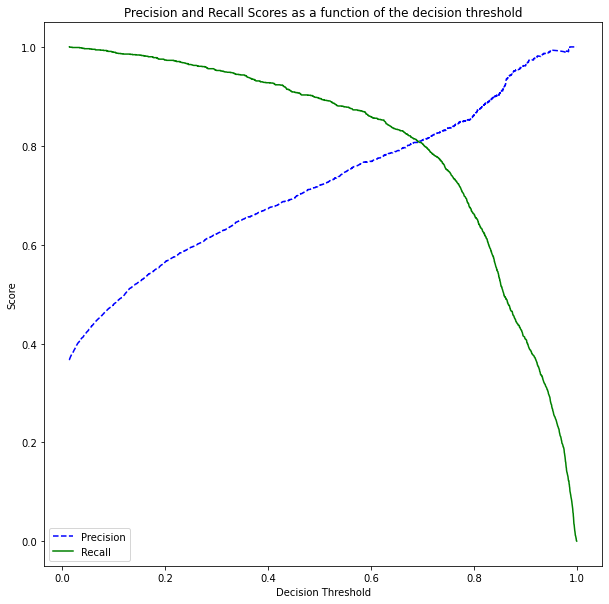

In [44]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

### Curva ROC

In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [46]:
ns_probs = [0 for _ in range(len(y_test))]

In [47]:
# predict probabilities
lr_probs = model.predict_proba(X_test)

In [48]:
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.954


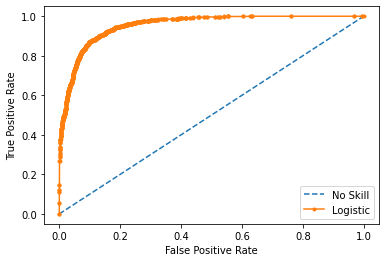

In [49]:
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [50]:
probabilidades = model.predict_proba(X_test)

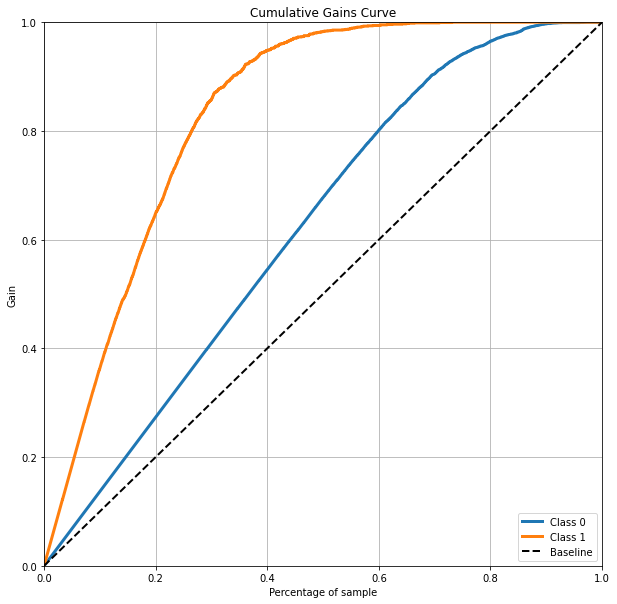

In [51]:
import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(y_test, probabilidades, figsize= (10,10))

plt.show()

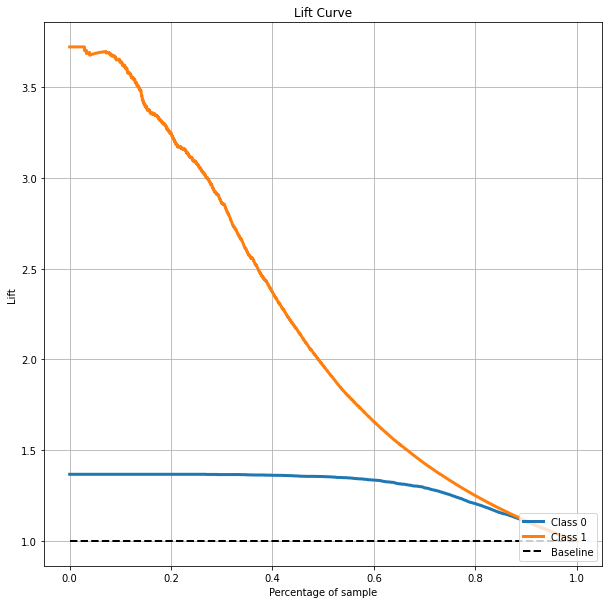

In [52]:
skplt.metrics.plot_lift_curve(y_test, probabilidades, figsize= (10,10))
plt.show()

### Curvas interactivas de recall, precision y KS

In [53]:
df1 = final1[['target', 'target.0', 'target.1']]

In [54]:
df1.head()

target  target.0  target.1
0       0  0.999059  0.000941
1       0  0.895624  0.104376
2       1  0.036486  0.963514
3       0  0.993246  0.006754
4       0  0.673287  0.326713

In [55]:
def get_scored_df():
    #labels = pd.read_csv(path_y_true, usecols=[id_col, y_true_col])
    labels = df1[['target']]
    #preds = pd.read_csv(path_y_pred)
    preds = df1[['target.1']]
    scored = pd.merge(labels, preds, left_index=True, right_index=True)
    scored = scored.rename(columns= {'target': 'y_true_col', 'target.1': 'y_pred_col'})
    scored['y_pred_col'] = scored['y_pred_col'].apply(lambda x: round(x*100, 2))
    return scored

In [56]:
scored_df = get_scored_df()

In [57]:
scored_df.head()

y_true_col  y_pred_col
0           0        0.09
1           0       10.44
2           1       96.35
3           0        0.68
4           0       32.67

In [58]:
#if sort_by_extra:
#    extra_data = pd.read_csv(path_extra_data,
#                             usecols=[id_col, extra_data_col])
#    scored_df = pd.merge(scored_df, extra_data, on=id_col)
#    scored_df.sort_values([y_pred_col, extra_data_col],
#                          ascending=False, inplace=True, ignore_index=True)
#    scored_df.drop(columns=[extra_data_col], inplace=True)
#else:
scored_df.sort_values('y_pred_col', ascending=False, inplace=True, ignore_index=True)

In [59]:
scored_df.head()  #ordenado por probabilidad de baja de mayor a menor

y_true_col  y_pred_col
0           1       99.94
1           1       99.90
2           1       99.88
3           1       99.87
4           1       99.86

In [60]:
to_hr = lambda x: "{:,}".format(x).replace(",", ".")

In [61]:
pps = [round(x, 3) for x in np.arange(0.1, 1.01, 0.01)]
precisions = list()
recalls = list()
#kss = list()
msgs_prec = list()
msgs_recall = list()
msgs_ks = list()
total_clientes = scored_df.shape[0] 
total_0s = scored_df['y_true_col'].value_counts()[0]
total_1s = scored_df['y_true_col'].value_counts()[1]
for pp in pps:
    slice_idx = int(total_clientes * pp)
    current_df = scored_df.loc[:slice_idx-1, :] #slice de scored_df (recordando que está ordenado por prob de baja)
    current_0s = current_df['y_true_col'].value_counts()[0] #cuantos 0's reales hay en el slice de scored_df
    current_1s = current_df['y_true_col'].value_counts()[1] #cuantos 1's reales hay en el slice de scored_df
    precisions.append(current_1s / slice_idx) #proporción de 1's en el slice
    msgs_prec.append("({} de {})".format(to_hr(current_1s), to_hr(slice_idx)))
    gain_1 = current_1s / total_1s #proporcion de 1's predichos sobre 1's verdaderos en el slice
    recalls.append(gain_1)
    msgs_recall.append("({} de {})".format(to_hr(current_1s), to_hr(total_1s)))
    #kss.append(gain_1 - (current_0s / total_0s))

In [62]:
metrics_df = pd.DataFrame({
    "PP": pps,
    "PRECISION": precisions,
    "RECALL": recalls,
    #"KS": kss,
    "msg_PRECISION": msgs_prec,
    "msg_RECALL": msgs_recall
})

In [63]:
metrics_df.head()

PP  PRECISION    RECALL msg_PRECISION      msg_RECALL
0  0.10   0.977273  0.363307  (602 de 616)  (602 de 1.657)
1  0.11   0.969027  0.396500  (657 de 678)  (657 de 1.657)
2  0.12   0.958051  0.427278  (708 de 739)  (708 de 1.657)
3  0.13   0.947566  0.458057  (759 de 801)  (759 de 1.657)
4  0.14   0.936195  0.487025  (807 de 862)  (807 de 1.657)

In [64]:
dfs = list()
for c, new_name in [("PRECISION", "PRECISION"),
                    ("RECALL", "RECALL")]:
                    #("KS", "KS")]:
    cdf = metrics_df[["PP", c]].copy()
    cdf.rename(columns={c: "VALOR"}, inplace=True)
    cdf["METRICA"] = new_name
    cdf["msg"] = metrics_df["msg_" + c] if c != "KS" else ""
    dfs.append(cdf)

In [65]:
plot_df = pd.concat(dfs)

In [66]:
plot_df.head(10)

PP     VALOR    METRICA               msg
0  0.10  0.977273  PRECISION      (602 de 616)
1  0.11  0.969027  PRECISION      (657 de 678)
2  0.12  0.958051  PRECISION      (708 de 739)
3  0.13  0.947566  PRECISION      (759 de 801)
4  0.14  0.936195  PRECISION      (807 de 862)
5  0.15  0.911255  PRECISION      (842 de 924)
6  0.16  0.901623  PRECISION      (889 de 986)
7  0.17  0.898758  PRECISION    (941 de 1.047)
8  0.18  0.891794  PRECISION    (989 de 1.109)
9  0.19  0.883006  PRECISION  (1.034 de 1.171)

In [67]:
import plotly.express as px

In [68]:
for c in ["PP", "VALOR"]:
    plot_df[c] = plot_df[c].apply(lambda x: x*100)

In [69]:
fig = px.line(
    plot_df, x="PP", y="VALOR", color="METRICA",
    width=1000, height=700, text=plot_df["msg"],
    hover_data=["METRICA"])
fig.update_layout(
    hovermode="x",
    font_size=15,
    legend_title_text=None,
    paper_bgcolor="rgba(0, 0, 0, 0)",
    title=dict(text="", font_size=25),
    xaxis=dict(range=[-1, 101], title=dict(text="POBLACION"), dtick=10),
    yaxis=dict(range=[0, 101], title=dict(text="VALOR METRICA"), dtick=10),
    font=dict(color="black"),
    hoverlabel=dict(
        font_size=16,
    )
)
fig.update_traces(mode="lines", hovertemplate="%{y:.1f}% %{text}")
fig.update_xaxes(showspikes=True, spikecolor="gray", spikesnap="cursor",
                 spikemode="across", ticksuffix="%")
fig.update_yaxes(ticksuffix="%")
fig.update_layout(spikedistance=1000, hoverdistance=100)
fig.show()